# Linear Regression

The idea is to explore a classifier named Logistic Regression.
However, to introduce the inner workings of such a model, let us start to analyse the Linear Regression one.

This will allow us to understant:
1. what is a linear model
2. define a cost function to train a model
3. how to fit a linear model given a cost function
4. Traditional optimization methods 

The linear regression models is defined by:
$$
h(x,m,b) = m\times x + b
$$

The tipical cost function to compute fit the linear regression is the following:
$$
e = \frac{\sum_{i=0}^{n}(y_i-h(x_i, m, b))^2}{2n}
$$

In [75]:
import os
import math
import nltk
import tqdm
import joblib
import numpy as np
import polars as pl
import seaborn as sns

import jax
import jax.numpy as jnp
import optimization.de as de
import optimization.pso as pso

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['figure.dpi'] = 72

In [76]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [77]:
data = pl.read_csv('../datasets/heart.csv')
data = data[['age', 'trestbps']]
data = data.rename({"age":"age", "trestbps":"bps"})
data.head()

age,bps
i64,i64
63,145
37,130
41,130
56,120
57,120


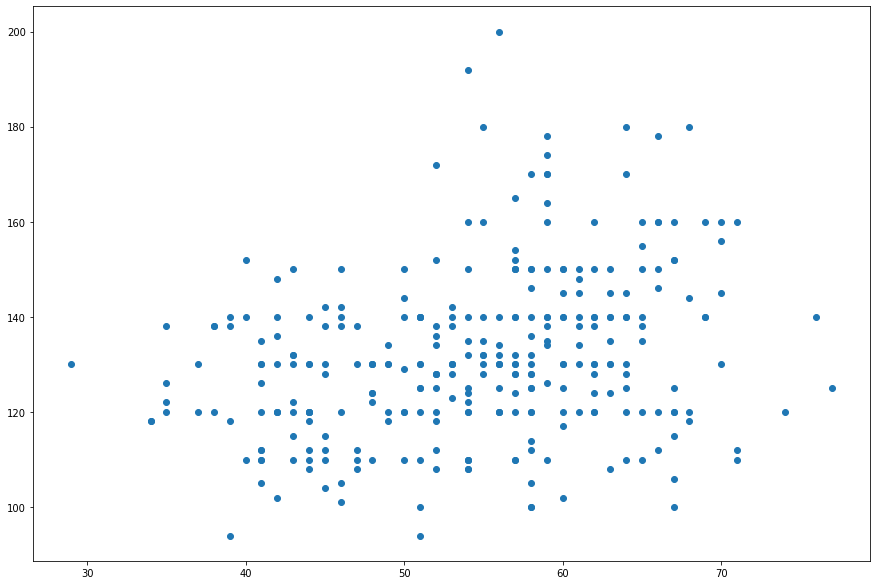

In [78]:
# divide the dataset
x = data[['age']]
y = data[['bps']]

# convert to numpy arrays
x = np.float32(x.to_numpy()[:,0])
y = np.float32(y.to_numpy()[:,0])

# plot the data
plt.plot(x, y, 'o')
plt.show()

In [79]:
def f(w):
    return x*w[0]+w[1]

def cost(w):
    y_hat = f(w)
    return np.mean(np.power((y-y_hat), 2))

class LRDE:
    def fit(self, x, y):
        bounds = np.asarray([(-5.0, 5.0), (-5.0, 5.0)])
        #solution = de.differential_evolution(cost, bounds, n_iter=300, verbose=True)
        solution = pso.particle_swarm_optimization(cost, bounds, n_iter=300, verbose=True)
        print(f'{solution[0]} ({solution[1]})')
        self.w = solution[0]
    
    def predict(self, x):
        return x*self.w[0]+self.w[1]
    
    def params(self):
        return self.w

In [80]:
lr = LRDE()
lr.fit(x, y)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:03<00:00, 92.21it/s]

[2.35156494 1.0072688 ] (560.2901000976562)


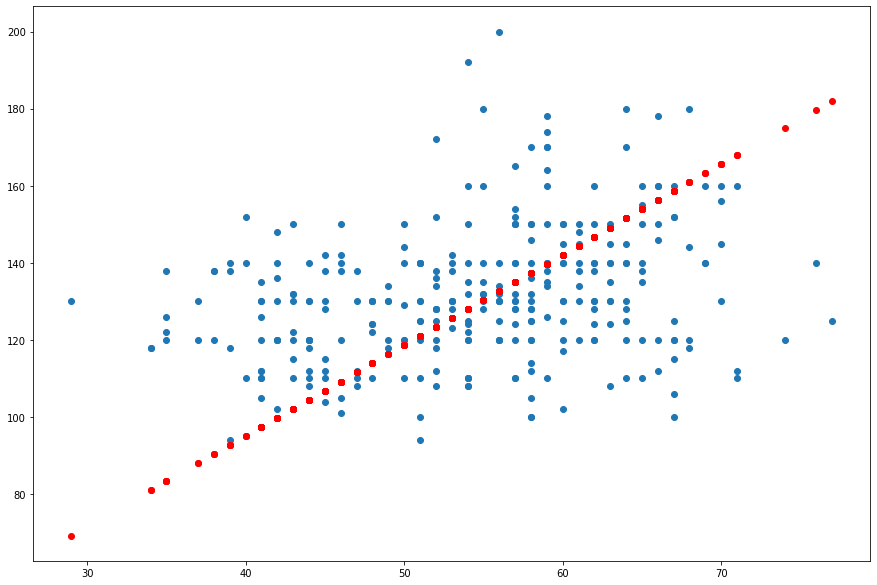

In [81]:
y_hat = f(lr.params())
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [82]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 23.670448303222656


In [83]:
class LR:
    def fit(self, X, Y, L=0.0001):
        self.m = 0.0
        self.c = 0.0
        for _ in tqdm.tqdm(range(1000)):
            Y_pred = self.m*X + self.c  # The current predicted value of Y
            D_m = np.average(-X * (Y - Y_pred))  # Derivative wrt m
            D_c = - np.average(Y - Y_pred)  # Derivative wrt c
            self.m = self.m - L * D_m  # Update m
            self.c = self.c - L * D_c  # Update c

    def predict(self, x):
        return x*self.m+self.c
    
    def params(self):
        return (self.m, self.c)

In [84]:
lr = LR()
lr.fit(x,y)
print(f'LR {lr.params()}')

100%|██████████| 1000/1000 [00:00<00:00, 75380.18it/s]

LR (2.3644457934076493, 0.31866106908321384)


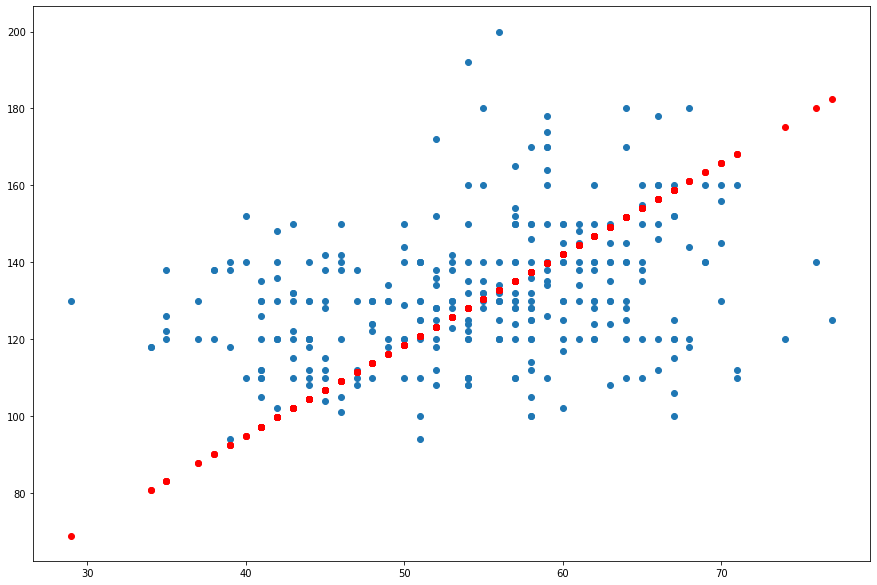

In [85]:
y_hat = f(lr.params())
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [86]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 23.75031089782715


In [87]:
def J(X, m, b, y):
    y_hat = x * m + b
    return jnp.mean((y_hat-y)**2.0)+1E-5*(m+b)**2

grad_X = jax.jit(jax.grad(J, argnums=1))
grad_b = jax.jit(jax.grad(J, argnums=2))

class LRAG:
    def fit(self, X, Y, L=0.0001):
        self.m = 0.0
        self.b = 0.0
        for _ in tqdm.tqdm(range(1000)):
            self.m = self.m - L * grad_X(X, self.m, self.b, Y)
            self.b = self.b - L * grad_b(X, self.m, self.b, Y)

    def predict(self, x):
        return x*self.m+self.b
    
    def params(self):
        return (self.m, self.b)

In [88]:
lr = LRAG()
lr.fit(x,y)
print(f'LR {lr.params()}')

100%|██████████| 1000/1000 [00:00<00:00, 16641.22it/s]

LR (Array(2.359972, dtype=float32, weak_type=True), Array(0.56865436, dtype=float32, weak_type=True))


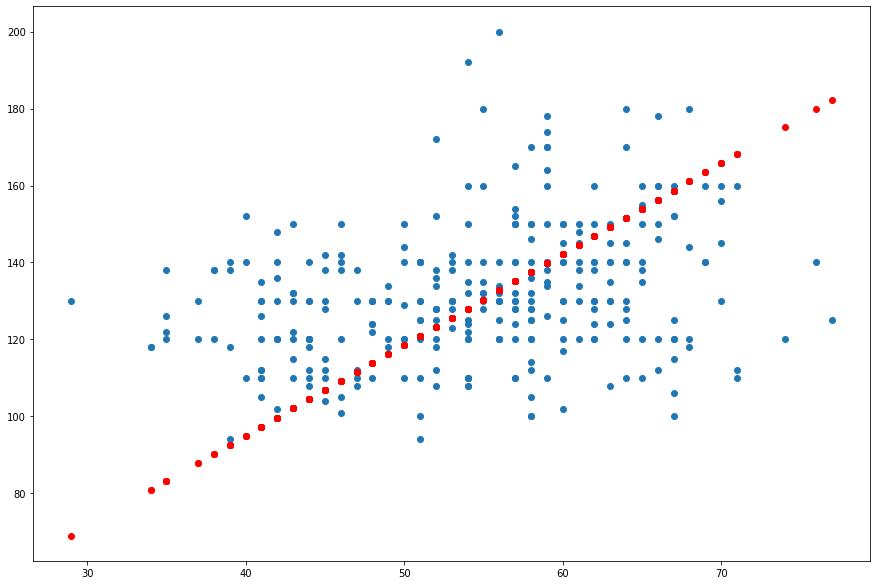

In [89]:
y_hat = f(lr.params())
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [90]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 23.72127914428711


In [91]:
class LRAGNewton:
    def fit(self, X, y, maxiter=1000, tol=1e-5):
        def J(w):
            y_hat = X * w[1] + w[0]
            return jnp.mean((y_hat-y)**2.0)+1E-5*(w[1] + w[0])**2
        
        g = jax.grad(J)
        h = jax.hessian(J)
        w = np.array([1.0, 1.0])
        
        for _ in range(maxiter):
            delta = np.linalg.solve(h(w), -g(w))
            w = w + delta
            if np.linalg.norm(delta) < tol:
                break
        
        self.m = w[1]
        self.b = w[0]

    def predict(self, x):
        return x*self.m+self.b
    
    def params(self):
        return (self.m, self.b)

In [92]:
lr = LRAGNewton()
lr.fit(x,y)
print(f'LR {lr.params()}')

LR (0.5401125290358557, 102.2587949998383)


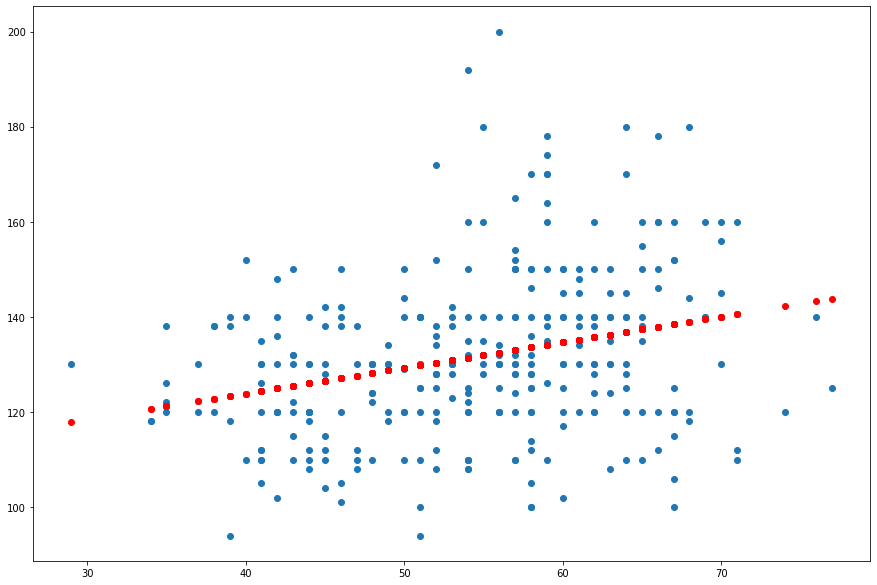

In [93]:
y_hat = f(lr.params())
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [94]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 16.812122344970703
